# Training Linear Models

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
from pathlib import Path
from sklearn.preprocessing import add_dummy_feature, PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.metrics import root_mean_squared_error
from math import ceil

### Linear Regression

#### The Normal Equation

In [2]:
np.random.seed(42)

m = 100  # number of instances
X = 2 * np.random.rand(m, 1)  # column vector
y = 4 + 3 * X + np.random.randn(m, 1)  # column vector

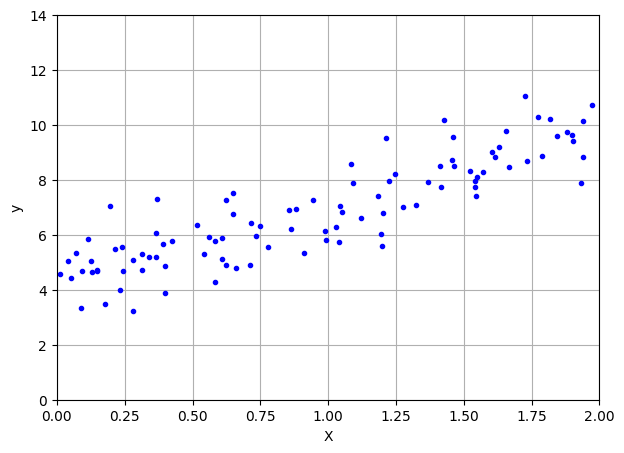

In [3]:
plt.figure(figsize=(7,5))
plt.plot(X, y, 'b.')
plt.axis([0, 2, 0, 14])
plt.xlabel("X")
plt.ylabel("y")
plt.grid()
plt.show()

In [4]:
X_b = add_dummy_feature(X) # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y

In [5]:
print(theta_best)

[[4.21509616]
 [2.77011339]]


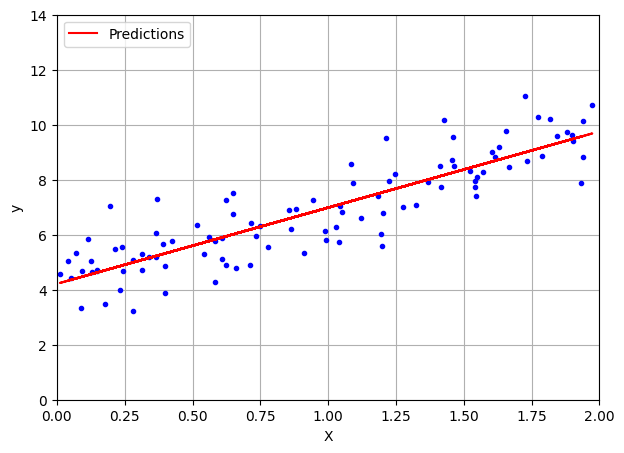

In [6]:
y_pred = X_b @ theta_best

plt.figure(figsize=(7,5))
plt.plot(X, y, 'b.')
plt.plot(X, y_pred, 'r-', label = "Predictions")
plt.axis([0, 2, 0, 14])
plt.xlabel("X")
plt.ylabel("y")
plt.grid()
plt.legend(loc="upper left")
plt.show()

In [7]:
# Scikit-Learn linear regression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [8]:
X_new = np.array([[0], [2]])
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

Could also compute the pseudoinverse (Moore-Penrose inverse) directly using np.linalg.pinv().

In [9]:
np.linalg.pinv(X_b) @ y

array([[4.21509616],
       [2.77011339]])

### Gradient Descent

The general idea of gradient descent is to tweak parameters iteratively (searching the models *parameter space*) in order to minimize a cost function.

#### Batch Gradient Descent

*Batch gradient descent* uses the whole batch of training data at every step. In other words, it involves calculations over the full training set X, at each gradient descent step. Gradient descent scales well with the number of features. Thus, training linear regression models with hundreds of thousands of features is much faster using gradient descent than using the Normal equation or SVD decomp.

In [10]:
eta = 0.1 # learning rate
n_epochs = 1000
m = len(X_b) # number of instances

np.random.seed(42)
theta = np.random.randn(2, 1) # randomly initialized params

for epoch in range(n_epochs):
    gradients = (2 / m) * X_b.T @ (X_b @ theta - y)
    theta = theta - eta * gradients

In [11]:
theta

array([[4.21509616],
       [2.77011339]])

In [12]:
X_new = np.array([[0], [2]])
X_new_b = add_dummy_feature(X_new)  # add x0 = 1 to each instance

In [13]:
def plot_gradient_descent(theta, eta):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_epochs = 1000
    n_shown = 20
    theta_path = []
    for epoch in range(n_epochs):
        if epoch < n_shown:
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.OrRd(epoch / n_shown + 0.15))
            plt.plot(X_new, y_predict, linestyle="solid", color=color)
        gradients = 2 / m * X_b.T @ (X_b @ theta - y)
        theta = theta - eta * gradients
        theta_path.append(theta)
    plt.xlabel("$x_1$")
    plt.axis([0, 2, 0, 15])
    plt.grid()
    plt.title(fr"$\eta = {eta}$")
    return theta_path

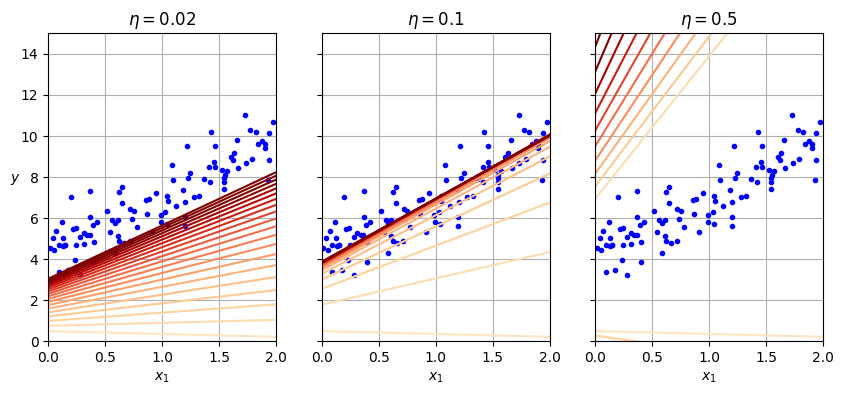

In [14]:

np.random.seed(42)
theta = np.random.randn(2,1) # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131)
plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0)
plt.subplot(132)
theta_path_bgd = plot_gradient_descent(theta, eta=0.1)
plt.gca().axes.yaxis.set_ticklabels([])
plt.subplot(133)
plt.gca().axes.yaxis.set_ticklabels([])
plot_gradient_descent(theta, eta=0.5)
plt.show()

### Stochastic Gradient Descent

*Stochastic gradient descent* picks a random instance in the training set at every step and computes the gradients based only on that instance. The irregularity of the cost function using SGD makes it possible to jump out of a local minima - so it has a better chance of finding the global minimum. The *learning schedule* can be set to decrease the learning rate at each iteration, the earlier iterations can jump out of local minima and as the learning rate decreases we can get closer to the global minimum.

In [15]:
theta_path_sgd = [] # stoe the path of theta in the parameter space for plotting

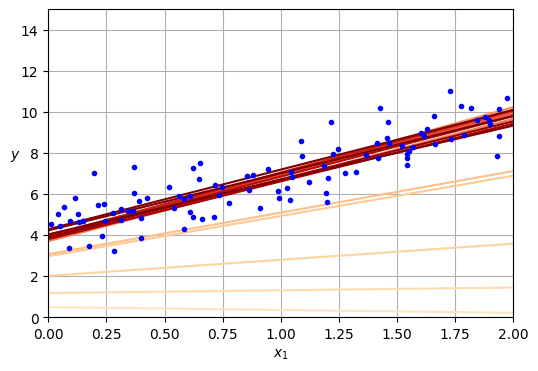

In [16]:
n_epochs = 50
t0, t1 = 5, 50 # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

np.random.seed(42)
theta = np.random.randn(2,1) # random initialization

n_shown = 20
plt.figure(figsize=(6,4))

for epoch in range(n_epochs):
    for iteration in range(m):

        # plot
        if epoch == 0 and iteration < n_shown:
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.OrRd(iteration / n_shown + 0.15))
            plt.plot(X_new, y_predict, color=color)

        random_index = np.random.randint(m)
        xi = X_b[random_index : random_index+1]
        yi = y[random_index : random_index+1]
        gradients = 2 * xi.T @ (xi @ theta - yi)
        eta = learning_schedule(epoch * m + iteration)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)

plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.show()

In [17]:
theta

array([[4.21076011],
       [2.74856079]])

In [18]:
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-5, penalty=None, eta0=0.01, n_iter_no_change=100, random_state=42)
sgd_reg.fit(X, y.ravel()) # ravel because fit() expects 1D targets

,loss,'squared_error'
,penalty,None
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,1e-05
,shuffle,True
,verbose,0
,epsilon,0.1
,random_state,42


In [19]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.21278812]), array([2.77270267]))

### Mini-Batch Gradient Descent

Mini-batch gradient descent computes the gradients on small random sets of instances called *mini-batches*. The main benefit of mini-batch GD over stocastic GD is that there is a performance boost from hardware optimization of matrix operations.

In [20]:
n_epochs = 50
minibatch_size = 20
n_batches_per_epoch = ceil(m / minibatch_size)

np.random.seed(42)
theta = np.random.randn(2, 1) # random initialization

t0, t1 = 200, 1000 # learning schedule hyperparameters

theta_path_mgd = []

for epoch in range(n_epochs):
    shuffle_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffle_indices]
    y_shuffled = y[shuffle_indices]
    for iteration in range(0, n_batches_per_epoch):
        idx = iteration * minibatch_size
        xi = X_b_shuffled[idx : idx + minibatch_size]
        yi = y_shuffled[idx : idx + minibatch_size]
        gradients = 2 / minibatch_size * xi.T @ (xi @ theta - yi)
        eta = learning_schedule(epoch * n_batches_per_epoch + iteration)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

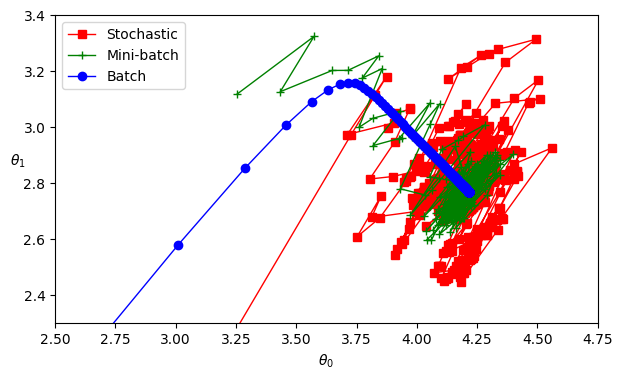

In [21]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:,0], theta_path_sgd[:,1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:,0], theta_path_mgd[:,1], "g-+", linewidth=1, label="Mini-batch")
plt.plot(theta_path_bgd[:,0], theta_path_bgd[:,1], "b-o", linewidth=1, label="Batch")
plt.axis([2.5, 4.75, 2.3, 3.4])
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$", rotation=0)
plt.legend(loc="upper left")
plt.show()

### Polynomial Regression

In [22]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)

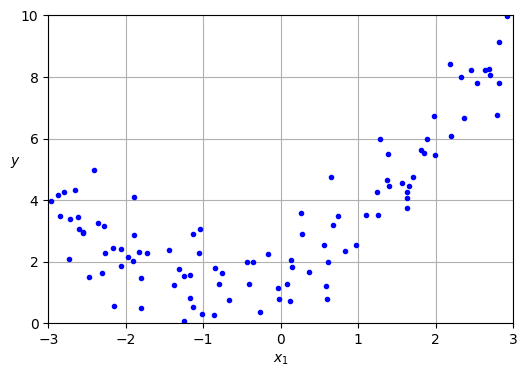

In [23]:
plt.figure(figsize=(6,4))
plt.plot(X, y, 'b.')
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.grid()
plt.show()

In [24]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [25]:
X_poly[0]

array([-0.75275929,  0.56664654])

In [26]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

In [27]:
X_new = np.linspace(-3, 3, 100).reshape(100,1)
X_new_poly = poly_features.fit_transform(X_new)
y_new = lin_reg.predict(X_new_poly)

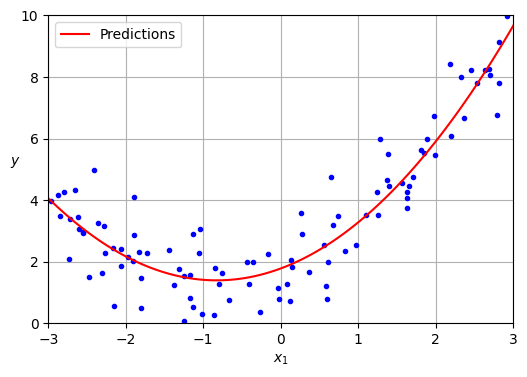

In [28]:
plt.figure(figsize=(6,4))
plt.plot(X, y, 'b.')
plt.plot(X_new, y_new, 'r-', label="Predictions")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.grid()
plt.legend(loc="upper left")
plt.show()

#### Learning curves

*Learning curves* help determine whether a model is too simple or too complex.

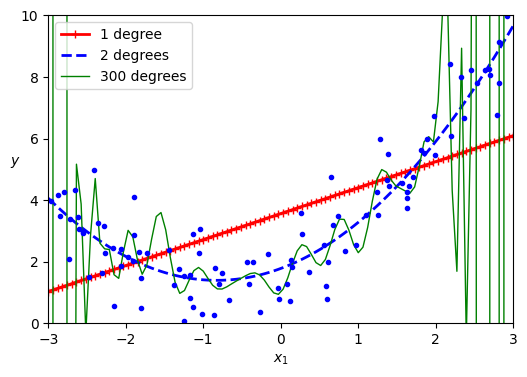

In [29]:
plt.figure(figsize=(6,4))

for style, width, degree in (("r-+",2,1), ("b--",2,2), ("g-",1,300)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = make_pipeline(polybig_features, std_scaler, lin_reg)
    polynomial_regression.fit(X,y)
    y_newbig = polynomial_regression.predict(X_new)
    label = f"{degree} degree{'s' if degree > 1 else ''}"
    plt.plot(X_new, y_newbig, style, label=label, linewidth=width)

plt.plot(X, y, 'b.')
plt.axis([-3, 3, 0, 10])
plt.legend(loc="upper left")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.show()


In [30]:
train_sizes, train_scores, valid_scores = learning_curve(LinearRegression(),
                                                         X, y, train_sizes=np.linspace(0.01, 1, 40), cv=5,
                                                         scoring="neg_root_mean_squared_error")

In [31]:
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

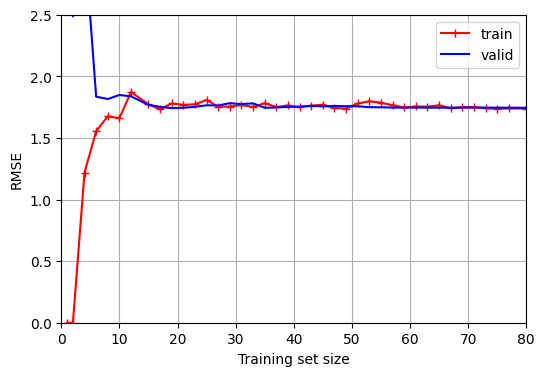

In [32]:
plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_errors, "r-+", label="train")
plt.plot(train_sizes, valid_errors, "b", label="valid")
plt.grid()
plt.legend(loc="upper right")
plt.axis([0, 80, 0, 2.5])
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.show()

The plateau in the fit (RMSE) of the training and validatin data as the set size increases suggests that the model is underfitting the data, because more instances doen't result in an increased fit (for the training data). If a model is underfitting data, more instances will not help.

In [33]:
polynomial_regression = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False),
    LinearRegression())

train_sizes, train_scores, valid_scores = learning_curve(polynomial_regression,
                                                         X, y, train_sizes=np.linspace(0.01,1,40), cv=5,
                                                         scoring="neg_root_mean_squared_error")

In [34]:
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

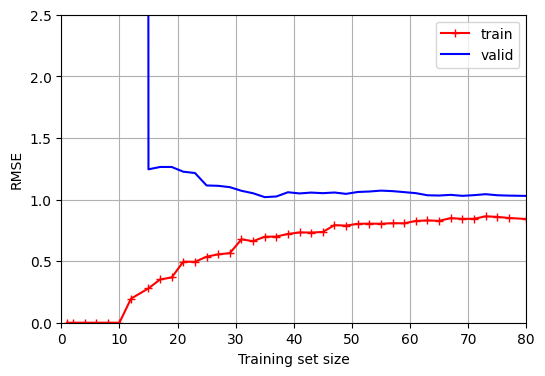

In [35]:
plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_errors, "r-+", label="train")
plt.plot(train_sizes, valid_errors, "b", label="valid")
plt.grid()
plt.legend(loc="upper right")
plt.axis([0, 80, 0, 2.5])
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.show()

### Regularized Linear Models

#### Ridge Regression

Also called *Tikhonov regularization* - a regularized version of linear regression.

In [36]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

In [37]:
ridge_reg = Ridge(alpha=0.1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([1.55325833])

In [38]:
sgd_reg = SGDRegressor(penalty="l2", alpha=0.1/m, tol=None,
                       max_iter=1000, eta0=0.01, random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.55302613])

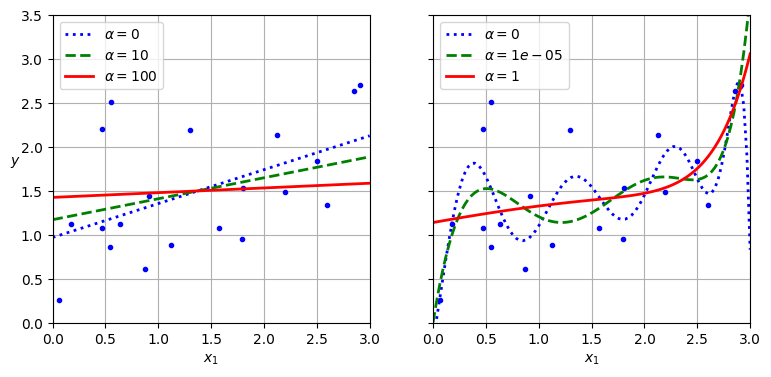

In [39]:
def plot_model(model_class, polynomial, alphas, **model_kwargs):
    plt.plot(X,y,"b.",linewidth=3)
    for alpha, style in zip(alphas, ("b:", "g--", "r-")):
        if alpha > 0:
            model = model_class(alpha, **model_kwargs)
        else:
            model = LinearRegression()
        if polynomial:
            model = make_pipeline(
                PolynomialFeatures(degree=10, include_bias=False),
                StandardScaler(),
                model)
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        plt.plot(X_new, y_new_regul, style, linewidth=2,
                 label=fr"$\alpha = {alpha}$")
        plt.legend(loc="upper left")
        plt.xlabel("$x_1$")
        plt.axis([0, 3, 0, 3.5])
        plt.grid()

plt.figure(figsize=(9, 4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)
plt.gca().axes.yaxis.set_ticklabels([])
plt.show()

#### Lasso Regression

*Least absolute shrinkage and selection operator* regression is another regularized version of linear regression. Instead of using the l2 norm like Ridge regression, Lasso regression adds an l1 norm term to the cost function.

In [40]:
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X,y)
lasso_reg.predict([[1.5]])

array([1.53788174])

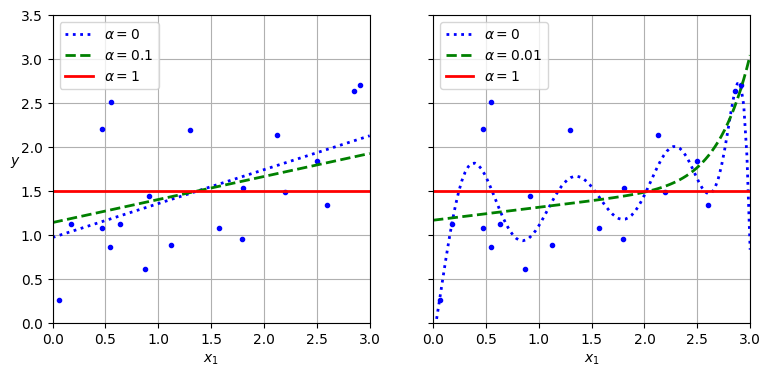

In [41]:
plt.figure(figsize=(9,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 1e-2, 1), random_state=42)
plt.gca().axes.yaxis.set_ticklabels([])
plt.show()

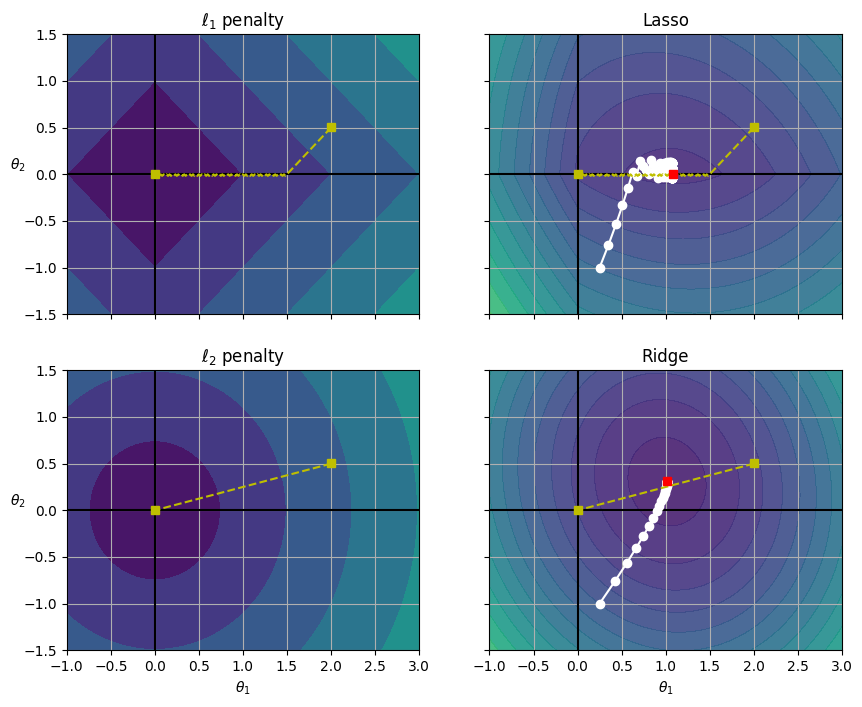

In [42]:
t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[1,1], [1,-1], [1,0.5]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1 / len(Xr) * ((T @ Xr.T - yr.T)**2).sum(axis=1)).reshape(t1.shape) # MSE

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(J.argmin(), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

def bgd_path(theta, X, y, l1, l2, core=1, eta=0.05, n_iterations=200):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = (core * 2 /len(X) * X.T @ (X @ theta - y) + l1 * np.sign(theta) + l2 * theta)
        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

fig, axes = plt.subplots(2,2,sharex=True, sharey=True, figsize=(10., 8))

for i, N, l1, l2, title in ((0, N1, 2.0, 0, "Lasso"), (1, N2, 0, 2.0, "Ridge")):
    JR = J + l1 * N1 + l2 * 0.5 * N2 **2

    tr_min_idx = np.unravel_index(JR.argmin(), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levels = np.exp(np.linspace(0, 1, 20)) - 1
    levelsJ = levels * (J.max() - J.min()) + J.min()
    levelsJR = levels * (JR.max() - JR.min()) + J.min()
    levelsN = np.linspace(0, N.max(), 10)

    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(theta = np.array([[2.0], [0.5]]), X=Xr, y=yr,
                      l1=np.sign(l1)/3, l2=np.sign(l2), core=0)
    
    ax = axes[i, 0]
    ax.grid()
    ax.axhline(y=0, color="k")
    ax.axvline(x=0, color="k")
    ax.contourf(t1, t2, N / 2.0, levels=levelsN)
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.set_title(fr"$\ell_{i + 1}$ penalty")
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$")
    ax.set_ylabel(r"$\theta_2$", rotation=0)

    ax = axes[i, 1]
    ax.grid()
    ax.axhline(y=0, color="k")
    ax.axvline(x=0, color="k")
    ax.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    ax.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.plot(t1r_min, t2r_min, "rs")
    ax.set_title(title)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$")

plt.show()


#### Elastic Net Regression

*Elastic net regression* is a middle ground between ridge and lasso regression. In general, it is good to have some regularization and plain linear regression should be avoided. Elastic net regression is preferred over lasso regression because lasso may behave erratically when the number of features is greater than the training instances or when several features are strongly correlated.

In [43]:
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X,y)
elastic_net.predict([[1.5]])

array([1.54333232])

#### Early stopping

This is when training is stopped as soon as the validation error reaches a minimum.

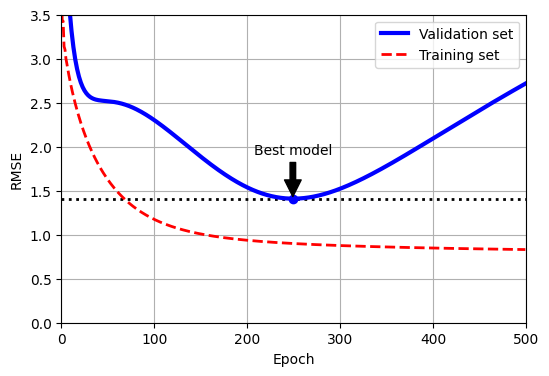

In [44]:
from copy import deepcopy

np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)
X_train, y_train = X[: m // 2], y[: m // 2, 0]
X_valid, y_valid = X[m // 2 :], y[m // 2 :, 0]

preprocessing = make_pipeline(PolynomialFeatures(degree=90, include_bias=False),
                              StandardScaler())
X_train_prep = preprocessing.fit_transform(X_train)
X_valid_prep = preprocessing.transform(X_valid)
sgd_reg = SGDRegressor(penalty=None, eta0=0.002, random_state=42)
n_epochs = 500
best_valid_rmse = float('inf')
train_errors, val_errors = [], [] 

for epoch in range(n_epochs):
    sgd_reg.partial_fit(X_train_prep, y_train)
    y_valid_predict = sgd_reg.predict(X_valid_prep)
    val_error = root_mean_squared_error(y_valid, y_valid_predict)
    if val_error < best_valid_rmse:
        best_valid_rmse = val_error
        best_model = deepcopy(sgd_reg)

    y_train_predict = sgd_reg.predict(X_train_prep)
    train_error = root_mean_squared_error(y_train, y_train_predict)
    val_errors.append(val_error)
    train_errors.append(train_error)

best_epoch = np.argmin(val_errors)
plt.figure(figsize=(6, 4))
plt.annotate('Best model',
             xy=(best_epoch, best_valid_rmse),
             xytext=(best_epoch, best_valid_rmse + 0.5),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.plot([0, n_epochs], [best_valid_rmse, best_valid_rmse], "k:", linewidth=2)
plt.plot(val_errors, "b-", linewidth=3, label="Validation set")
plt.plot(best_epoch, best_valid_rmse, "bo")
plt.plot(train_errors, "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.axis([0, n_epochs, 0, 3.5])
plt.grid()
plt.show()

### Logistic Regression

In [45]:
-np.log(0.999)

np.float64(0.0010005003335835344)

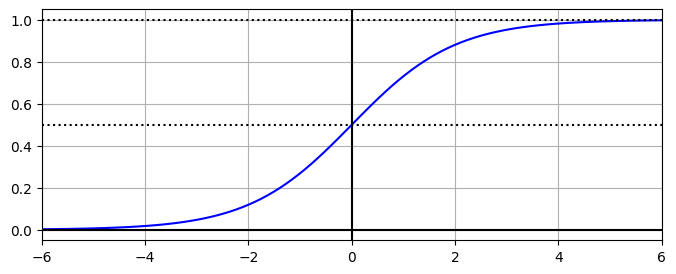

In [46]:
lim = 6
t = np.linspace(-lim, lim, 100)
sig = 1 / (1 + np.exp(-t))

plt.figure(figsize=(8,3))
plt.plot(t, sig, 'b-')
plt.plot([-lim, lim], [0.5, 0.5], "k:")
plt.plot([-lim, lim], [1, 1], "k:")
plt.plot([0, 0], [-0.05, 1.05], "k-")
plt.plot([-lim, lim], [0, 0], "k-")
plt.axis([-lim, lim, -0.05, 1.05])
plt.grid()
plt.show()

#### Descision Boundaries

In [47]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
list(iris)

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [48]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

In [49]:
iris.data.head(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2


In [50]:
iris.target.head(3)

0    0
1    0
2    0
Name: target, dtype: int64

In [51]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [52]:
X = iris.data[["petal width (cm)"]].values
y = iris.target_names[iris.target] == "virginica"

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [53]:
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [54]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:,1] >= 0.5][0,0]
decision_boundary

np.float64(1.6516516516516517)

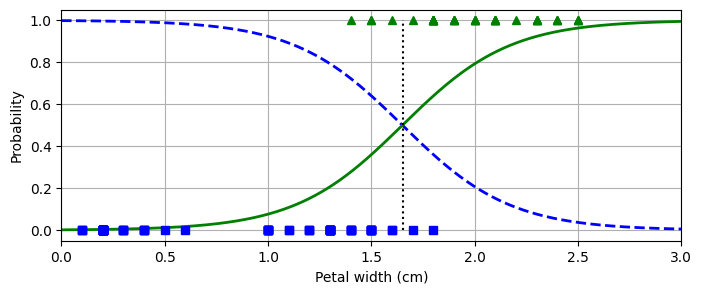

In [55]:
plt.figure(figsize=(8,3))
plt.plot(X_new, y_proba[:, 0], 'b--', linewidth=2, label="Not Iris virginica proba")
plt.plot(X_new, y_proba[:, 1], 'g-', linewidth=2, label="Iris virginica proba")
plt.plot([decision_boundary, decision_boundary], [0, 1], 'k:')
plt.plot(X_train[y_train==0], y_train[y_train == 0], 'bs')
plt.plot(X_train[y_train==1], y_train[y_train == 1], 'g^')
plt.xlabel("Petal width (cm)")
plt.ylabel("Probability")
plt.axis([0, 3, -0.05, 1.05])
plt.grid()
plt.show()

In [56]:
log_reg.predict([[1.7], [1.5]])

array([ True, False])

In [57]:
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target_names[iris.target] == "virginica"
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [58]:
log_reg = LogisticRegression(C=2, random_state=42)
log_reg.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,2
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


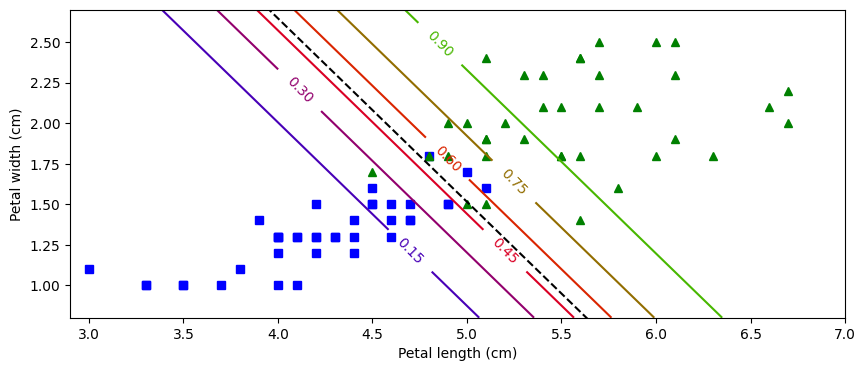

In [59]:
x0, x1 = np.meshgrid(np.linspace(2.9, 7, 500).reshape(-1, 1),
                     np.linspace(0.8, 2.7, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]
y_proba = log_reg.predict_proba(X_new)
zz = y_proba[:,1].reshape(x0.shape)

left_right = np.array([2.9, 7])
boundary = -((log_reg.coef_[0,0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0,1])
plt.figure(figsize=(10, 4))
plt.plot(X_train[y_train == 0, 0], X_train[y_train == 0, 1], 'bs')
plt.plot(X_train[y_train == 1, 0], X_train[y_train == 1, 1], 'g^')
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)
plt.clabel(contour, inline=1)
plt.plot(left_right, boundary, "k--")
plt.axis([2.9, 7, 0.8, 2.7])
plt.xlabel("Petal length (cm)")
plt.ylabel("Petal width (cm)")
plt.show()


#### Softmax Regression



In [60]:
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

softmax_reg = LogisticRegression(C=30, random_state=42)
softmax_reg.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,30
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [61]:
softmax_reg.predict([[5, 2]])

array([2])

In [62]:
softmax_reg.predict_proba([[5, 2]]).round(2)

array([[0.  , 0.04, 0.96]])

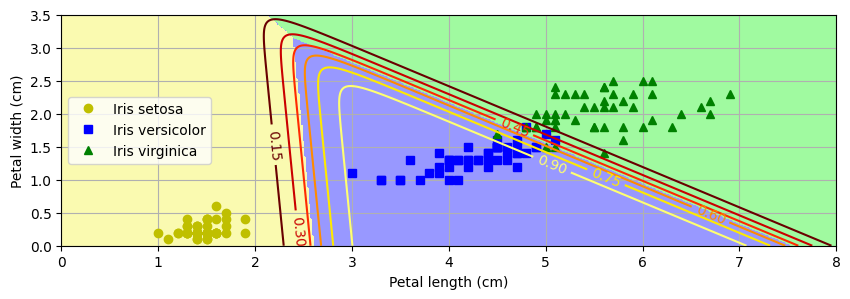

In [63]:
from matplotlib.colors import ListedColormap

custom_cmap = ListedColormap(["#fafab0", "#9898ff", "#a0faa0"])

x0, x1 = np.meshgrid(np.linspace(0, 8, 500).reshape(-1,1),
                     np.linspace(0, 3.5, 200).reshape(-1,1))
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10,3))
plt.plot(X[y==0, 0], X[y==0, 1], 'yo', label = "Iris setosa")
plt.plot(X[y==1, 0], X[y==1, 1], 'bs', label = "Iris versicolor")
plt.plot(X[y==2, 0], X[y==2, 1], 'g^', label = "Iris virginica")
plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap = "hot")
plt.clabel(contour, inline=1)
plt.legend(loc = "center left")
plt.xlabel("Petal length (cm)")
plt.ylabel("Petal width (cm)")
plt.grid()
plt.show()

### Exercise 12. Batch Gradient Descent with early stopping for Softmax Regression

In [64]:
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris["target"].values

In [65]:
X_with_bias = np.c_[np.ones(len(X)), X]

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X_with_bias, y, test_size=0.2, random_state=42)

In [67]:
test_ratio = 0.2
validation_ratio = 0.2
total_size = len(X_with_bias)

test_size = int(total_size * test_ratio)
validation_size = int(total_size * validation_ratio)
train_size = total_size - test_size - validation_size

np.random.seed(42)
rnd_indices = np.random.permutation(total_size)

X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
y_valid = y[rnd_indices[train_size:-test_size]]

In [68]:
def to_one_hot(y):
    return np.diag(np.ones(y.max()+1))[y]

In [69]:
y_train[:10]

array([0, 0, 1, 0, 0, 2, 1, 0, 0, 0])

In [70]:
to_one_hot(y_train)[:10]

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [71]:
y_train_one_hot = to_one_hot(y_train)
y_valid_one_hot = to_one_hot(y_valid)
y_test_one_hot = to_one_hot(y_test)


In [72]:
mean = X_train[:,1:].mean(axis=0)
std = X_train[:,1:].std(axis=0)
X_train[:, 1:] = (X_train[:,1:] - mean) / std
X_valid[:, 1:] = (X_valid[:,1:] - mean) / std
X_test[:, 1:] = (X_test[:,1:] - mean) / std

In [73]:
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = exps.sum(axis=1, keepdims=True)
    return exps/exp_sums

In [74]:
n_inputs = X_train.shape[1]
n_outputs = len(np.unique(y_train))

In [75]:
eta = 0.5
n_epochs = 50_001
m = len(X_train)
epsilon = 1e-5
C = 100  # regularization hyperparameter
best_loss = np.inf

np.random.seed(42)
Theta = np.random.randn(n_inputs, n_outputs)

for epoch in range(n_epochs):
    logits = X_train @ Theta
    Y_proba = softmax(logits)
    Y_proba_valid = softmax(X_valid @ Theta)
    xentropy_losses = -(y_valid_one_hot * np.log(Y_proba_valid + epsilon))
    l2_loss = 1 / 2 * (Theta[1:] ** 2).sum()
    total_loss = xentropy_losses.sum(axis=1).mean() + 1 / C * l2_loss
    if epoch % 1000 == 0:
        print(epoch, total_loss.round(4))
    if total_loss < best_loss:
        best_loss = total_loss
    else:
        print(epoch - 1, best_loss.round(4))
        print(epoch, total_loss.round(4), "early stopping!")
        break
    error = Y_proba - y_train_one_hot
    gradients = 1 / m * X_train.T @ error
    gradients += np.r_[np.zeros([1, n_outputs]), 1 / C * Theta[1:]]
    Theta = Theta - eta * gradients

0 3.7269
1000 0.3118
1184 0.3118
1185 0.3118 early stopping!


In [76]:
Theta

array([[-0.20373494,  2.11932541, -0.90945208],
       [-2.28209114,  0.13778739,  2.14708024],
       [-2.03094282, -0.34193244,  2.37781671]])

In [77]:
logits = X_valid @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_valid).mean()
accuracy_score

np.float64(0.9)

In [86]:
custom_cmap = mpl.colors.ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])

x0, x1 = np.meshgrid(np.linspace(0, 8, 500).reshape(-1, 1),
                     np.linspace(0, 3.5, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new = (X_new - mean) / std
X_new_with_bias = np.c_[np.ones(len(X_new)), X_new]

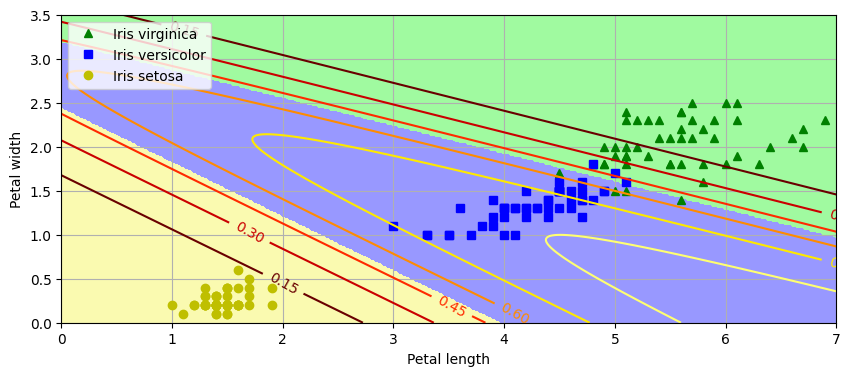

In [87]:
logits = X_new_with_bias @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y == 2, 0], X[y == 2, 1], "g^", label="Iris virginica")
plt.plot(X[y == 1, 0], X[y == 1, 1], "bs", label="Iris versicolor")
plt.plot(X[y == 0, 0], X[y == 0, 1], "yo", label="Iris setosa")

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap="hot")
plt.clabel(contour, inline=1)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.axis([0, 7, 0, 3.5])
plt.grid()
plt.show()